In [157]:
from openpyxl import workbook,load_workbook,drawing
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

pd.set_option("display.precision", 2)
pd.options.mode.chained_assignment = None  # default='warn'

### Dataframe after loading the Excel sheet with Null Values for empty cells.

In [133]:
df = pd.read_excel('data/sample_data.xlsx',header=None)
df = df.dropna(how='all')
df

,0,1,2,3,4
0,2021,NaN,NaN,NaN,NaN
1,Name,Q1,Q2,Q3,Q4
2,AXYM,20,32,14,17
3,FFRT,23,12,17,14
4,RDTY,20,32,14,17
5,KRTQ,23,12,17,14
19,2022,NaN,NaN,NaN,NaN
20,Name,Q1,Q2,Q3,Q4
21,AXYM,21,35,17,13
22,FFRT,34,18,15,32


### Different Dataframe Titles (Yearly data in our sample)

In [134]:
df[df.isna().any(axis=1)]

,0,1,2,3,4
0,2021,NaN,NaN,NaN,NaN
19,2022,NaN,NaN,NaN,NaN


In [135]:
ylist = df[df.isna().any(axis=1)][0].to_list()

In [136]:
ylist

[2021, 2022]

### Seperating the different datasets

In [137]:
columns = df.iloc[1,:].to_list() ## names of columns
rows_per_table =int((len(df)-4)/len(ylist))
dflist = []
start_loc=2
for i in ylist:
    dftmp = df.iloc[start_loc:start_loc+4,:]
    dftmp.columns = columns
    dftmp['Year'] = i
    dflist.append(dftmp)
    start_loc +=(rows_per_table+2)

In [138]:
dflist[0]

,Name,Q1,Q2,Q3,Q4,Year
2,AXYM,20,32,14,17,2021
3,FFRT,23,12,17,14,2021
4,RDTY,20,32,14,17,2021
5,KRTQ,23,12,17,14,2021


In [139]:
dflist[1]

,Name,Q1,Q2,Q3,Q4,Year
21,AXYM,21,35,17,13,2022
22,FFRT,34,18,15,32,2022
23,RDTY,11,56,12,25,2022
24,KRTQ,33,25,11,10,2022


### Merging datasets by columns

In [140]:
dfall = pd.merge(dflist[0].set_index('Name'),dflist[1].set_index('Name'),left_index=True,right_index=True,how='outer')

In [141]:
dfall

,Q1_x,Q2_x,Q3_x,Q4_x,Year_x,Q1_y,Q2_y,Q3_y,Q4_y,Year_y
Name,,,,,,,,,,
AXYM,20,32,14,17,2021,21,35,17,13,2022
FFRT,23,12,17,14,2021,34,18,15,32,2022
RDTY,20,32,14,17,2021,11,56,12,25,2022
KRTQ,23,12,17,14,2021,33,25,11,10,2022


### Printing Bar Graphs per Organization.

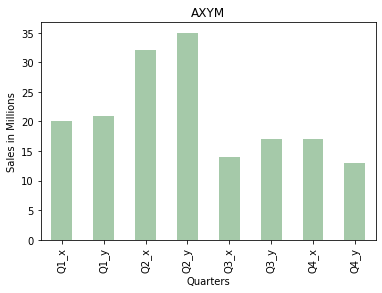

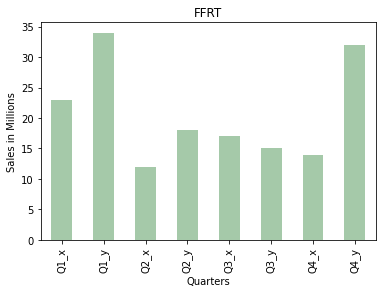

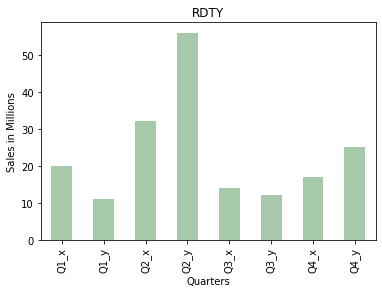

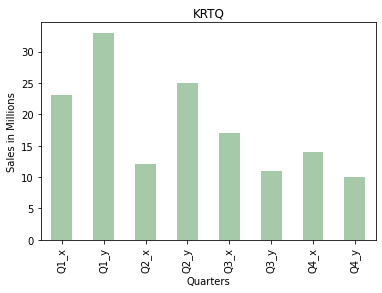

In [142]:
for i in dfall.index:
    filter = dfall.loc[i,:]
    filter[sorted([col for col in dfall.columns if 'Q' in col])].plot.bar(color='#a5c9a9')
    plt.title(i)
    plt.xlabel('Quarters')
    plt.ylabel('Sales in Millions')
    plt.show()

In [143]:
columns = [col for col in columns if 'Q' in col]
columns

['Q1', 'Q2', 'Q3', 'Q4']

### Generating YOY Quarterly diffs        = Q1_y - Q1_x 
### Generating %age change YOY by Quarter = ((Q1_y - Q1_x)/Q1_x)*100

In [144]:
for i in columns:
    dfall[f'{i}_diff'] = dfall[f'{i}_y']-dfall[f'{i}_x']
    dfall[f'{i}_%chg'] = (dfall[f'{i}_diff']/dfall[f'{i}_x'])*100

### Final DataFrame with diff and %age change YOY for each Quarter for all Organizations

In [145]:
dfall

,Q1_x,Q2_x,Q3_x,Q4_x,Year_x,Q1_y,Q2_y,Q3_y,Q4_y,Year_y,Q1_diff,Q1_%chg,Q2_diff,Q2_%chg,Q3_diff,Q3_%chg,Q4_diff,Q4_%chg
Name,,,,,,,,,,,,,,,,,,
AXYM,20,32,14,17,2021,21,35,17,13,2022,1,5.0,3,9.38,3,21.43,-4,-23.53
FFRT,23,12,17,14,2021,34,18,15,32,2022,11,47.83,6,50.0,-2,-11.76,18,128.57
RDTY,20,32,14,17,2021,11,56,12,25,2022,-9,-45.0,24,75.0,-2,-14.29,8,47.06
KRTQ,23,12,17,14,2021,33,25,11,10,2022,10,43.48,13,108.33,-6,-35.29,-4,-28.57


### %age diff Plots for each Organization. 

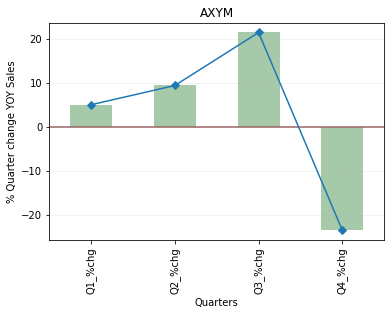

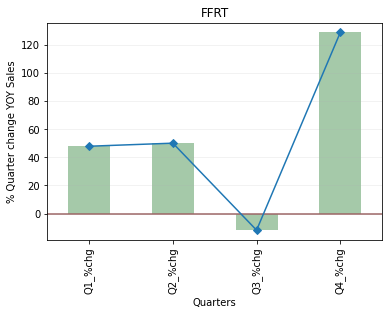

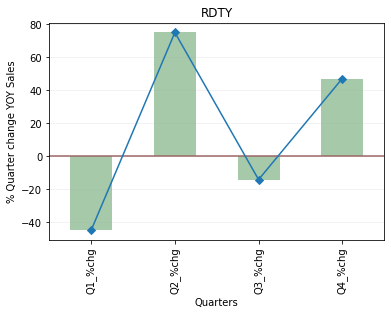

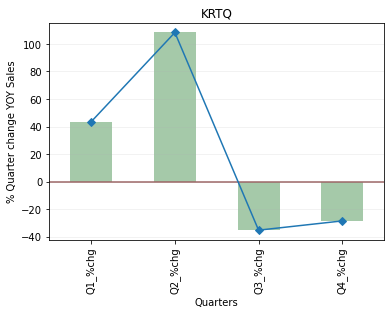

In [146]:
for i in dfall.index:
    filter = dfall.loc[i,:]
    filter_cols = sorted([col for col in dfall.columns if 'chg' in col])
    plt.axhline(y = 0, color = '#9c6565', linestyle = '-')
    filter[filter_cols].plot(zorder=5,marker='D')
    filter[filter_cols].plot(kind='bar', color='#a5c9a9', zorder=1)
    plt.title(i)
    plt.xlabel('Quarters')
    plt.ylabel('% Quarter change YOY Sales')
    plt.grid(axis='y',alpha=0.2)
    plt.savefig(f"images/diff_plt_{i}.png", dpi = 100,bbox_inches='tight')  ## Write Images to file
    plt.show()

### Write Final Dataframe and Above Graphs into the same Excel Sheet in 2 different tabs

In [147]:
wb = load_workbook('data/sample_data.xlsx')
ws = wb.create_sheet('%age_diff_graphs')
for index,imgfile in enumerate(glob('images/diff*.png')):
    img = drawing.image.Image(imgfile)
    ws.add_image(img,f'A{(index*22)+1}') ## Add space between two images by increasing row index = (index * 22) +1
    wb.save('data/sample_data.xlsx')

In [158]:
## Rounding off all %change columns to 2 decimal points
for i in filter_cols:
    dfall[i] = dfall[i].astype('float').round(2)


with pd.ExcelWriter('data/sample_data.xlsx', engine = 'openpyxl',mode='a') as writer:  
    dfall.to_excel(writer, sheet_name = 'Final_Data')